In [1]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

In [2]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999

In [3]:
plt.rcParams["figure.figsize"] = (20,5)

### Import data

In [4]:
df_product = pd.read_pickle('data/all_products_no_dup.pkl') # product scraped 4379 products 

In [5]:
df_category_map = pd.read_csv('data/category_map.csv')

In [6]:
mapper1 = df_category_map.set_index("category")['Re_category_level1'].to_dict()

In [7]:
mapper2 = df_category_map.set_index("category")['Re_category_level2'].to_dict()

In [8]:
df_reviews = pd.read_pickle('data/all_reviews_no_dup.pkl')

In [9]:
df_product_list = pd.read_parquet('data/sephora_historical_data_april_2020.parquet') # total of 9168 products

In [10]:
#add Product ID to df_product_list. it is from the URL. Unique ID for each product (per web page )
df_product_list['Product_id'] = df_product_list['URL'].str.findall('P[0-9]{4,15}').apply(lambda x: x[0])

In [11]:
#map category- the category in product list is in the lowerest level. We map them to the highest level based on Sephora website
# we also create a lower level.
df_product_list['category_level1']= df_product_list['category'].map(mapper1)
df_product_list['category_level2']= df_product_list['category'].map(mapper2)

In [12]:
# set product id as the index to create mapper for df_review (key is the product id)
df_product_list_2=df_product_list.set_index("Product_id")

In [13]:
mapper_product_category_1 = df_product_list_2['category_level1'].to_dict()
mapper_product_category_2 = df_product_list_2['category_level2'].to_dict()

In [14]:
#check if Kaggle data has any duplication 
df_product_list[df_product_list.duplicated(subset = ['Product_id'])]

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,URL,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,Product_id,category_level1,category_level2


In [15]:
#how to get the data in scope:  due to the limite, we limit the scope: rating above or equal to 4 and number of review above 50
df_product_b42020 = df_product_list.loc[(df_product_list["rating"]>=4) & (df_product_list["number_of_reviews"]>=50),:].copy()
#delete the wrong value approx. 20

In [16]:
df_product_b42020.shape

(3960, 24)

In [17]:
df_product_b42020['number_of_reviews_2020'] = df_product_b42020['number_of_reviews'] 

In [18]:
df_product_b42020['rating_2020'] = df_product_b42020['rating'] 

In [19]:
df_product_b42020_temp=df_product_b42020[['Product_id','name','size','brand','category','category_level1','category_level2','number_of_reviews_2020','rating_2020','love','price','value_price','URL']]

In [20]:
#df_product_b42020_temp.describe()

In [21]:
#total product scrapped
df_product.shape

(4379, 19)

In [22]:
#selecte products in the scope(3960 in product_b4_2020; 3902 products after2020.)
df_product_af2020=df_product.loc[df_product['Product_id_original'].isin(df_product_b42020['Product_id'])].copy()

## there are 58 products have no reviews in April 2021: 3960->3902; reasons: products no longer existed or Sephera has clear all reviews of the product

3902 products are the final products in this analysis 

In [23]:
#Rename the columns 
df_product_af2020['number_of_reviews_2021']=df_product_af2020['TotalReviewCount']

In [24]:
df_product_af2020['rating_2021']=df_product_af2020['AverageOverallRating']

In [25]:
df_product_af2020_temp = df_product_af2020[["Product_id_original","number_of_reviews_2021",'rating_2021','FirstSubmissionTime']]

In [26]:
#merge the data frame product_af_2020 and product_b4_2020
df_product_2020_2021_temp = pd.merge(df_product_af2020_temp,df_product_b42020_temp, left_on = 'Product_id_original', right_on = 'Product_id', how = 'left', indicator = True)

In [27]:
df_product_2020_2021_temp['_merge'].value_counts()

both          3902
right_only       0
left_only        0
Name: _merge, dtype: int64

In [28]:
#selected needed columns
df_product_2020_2021 = df_product_2020_2021_temp[['Product_id','name',"size","brand","category",'category_level1','category_level2',"price",'value_price','URL','love','FirstSubmissionTime',
                           'number_of_reviews_2021','number_of_reviews_2020','rating_2021','rating_2020']].copy()

In [29]:
df_product_2020_2021['number_of_reviews_2021'] =df_product_2020_2021['number_of_reviews_2021'].astype(int)

<AxesSubplot:ylabel='Frequency'>

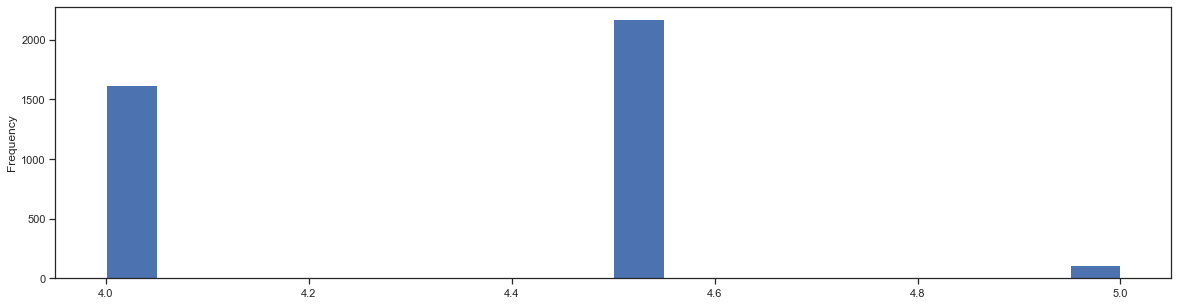

In [30]:
df_product_2020_2021['rating_2020'].plot(kind = 'hist', bins = 20)

<AxesSubplot:ylabel='Frequency'>

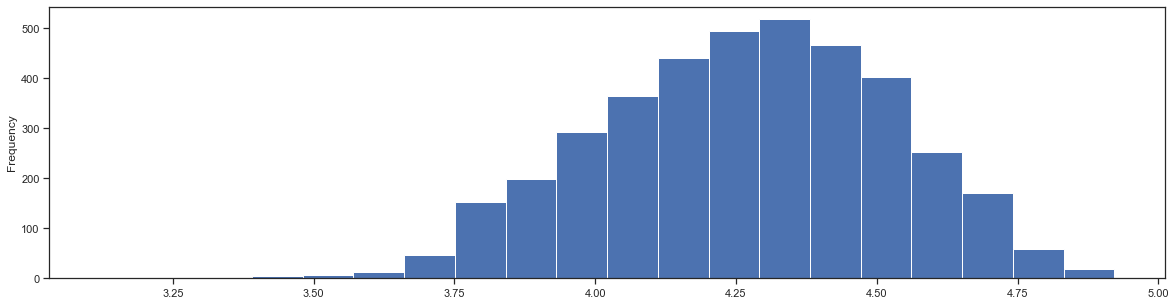

In [31]:
df_product_2020_2021['rating_2021'].plot(kind = 'hist', bins = 20)

In [32]:
#df_product_2020_2021.describe()

### Create columns for analysis 

- **product_life**-> this will help us to calcuate the average number of reviews per year 
- **product_life above 1 year** and **product _life above 2 years **
- 
- there are 14 products are new/upgraded. They have reviews before 2020.4. however, there is some update, the first submission date is after 2020.4. Therefore, we treated them as new products launched during pandamic. 

In [33]:
df_product_2020_2021["FirstSubmissionTime"].max()

'2021-04-01T15:26:15.000+00:00'

In [34]:
#product life
df_product_2020_2021['product_life'] = (pd.to_datetime("2021-04-2")-pd.to_datetime(df_product_2020_2021["FirstSubmissionTime"]).dt.tz_localize(None))/pd.Timedelta('365D')

<AxesSubplot:ylabel='Frequency'>

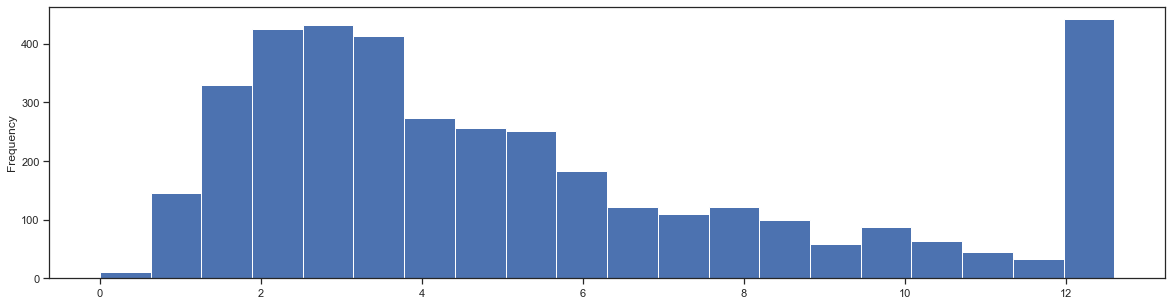

In [35]:
df_product_2020_2021['product_life'].plot(kind = 'hist', bins = 20)

note that there are some product has less than one year product life. This is due to the update of the product. 
The product has been updated, therefore, the reviews were also updated accordingly

In [36]:
#tag product_life more than 1 year 
df_product_2020_2021['product_life_above_1'] = df_product_2020_2021['product_life'].\
                                               apply(lambda x: True if x >=1 else False)

In [37]:
df_product_2020_2021['product_life_above_1'].value_counts()

True     3888
False      14
Name: product_life_above_1, dtype: int64

In [38]:
#tag product_life more than 2 year 
df_product_2020_2021['product_life_above_2'] = df_product_2020_2021['product_life'].\
                                               apply(lambda x: True if x >=2 else False)

In [39]:
df_product_2020_2021['product_life_above_2'].value_counts()

True     3319
False     583
Name: product_life_above_2, dtype: int64

## combine with review data to calcuate the review numbers and rating during pandamic and b4 pandamic 

In [40]:
#convert review_submission_time to date format
df_reviews['review_submission_time']=pd.to_datetime(df_reviews["SubmissionTime"]).dt.tz_localize(None)

In [41]:
df_reviews["review_submission_time_d"] = pd.to_datetime(df_reviews["review_submission_time"]).dt.floor('D')

In [42]:
#to count the # reviews per product during pandamic, we select the review_submision time after 2020-04-01 
df_reviews_2021 = df_reviews.loc[df_reviews['review_submission_time']>= pd.to_datetime("2020-04-01"),:].copy()

In [43]:
#groupby product id
df_reviews_2021_temp = df_reviews_2021.groupby('Product_id_original').agg({"Rating": "mean", "Id": "count",'review_submission_time':'min'})\
.reset_index().rename(columns = {"Product_id_original":'Product_id', 'Rating':'r_Rating_avg_2021',\
                                 'Id':'r_Review_count_2021','review_submission_time':'r_Submission_min_2021'})

In [44]:
# we have reviews for 4224 products 
df_reviews_2021_temp.shape

(4224, 4)

In [45]:
# first filter all submission time after 2020-4-1, then filter the min submission time is before 2020-5-1
# there are the product that have full reviews of 2020-4 to 2021 
df_reviews_2021_temp_1year = df_reviews_2021_temp[df_reviews_2021_temp['r_Submission_min_2021']< pd.to_datetime('2020-05-01')]

In [46]:
df_reviews_2021_temp_1year.head(2)

,Product_id,r_Rating_avg_2021,r_Review_count_2021,r_Submission_min_2021
0,P04546871,4.203704,54,2020-04-01 18:47:53
1,P04897543,4.031915,94,2020-04-04 03:09:44


In [47]:
df_reviews_2021_temp_1year.shape

(3533, 4)

In [48]:
3533/4224

0.8364109848484849

### 99% products have product life more than 1 year. However, due to the limit of scraping (latest 3100 review), the review data will only cover 83d%. The rest 16% we will fillna with (review count 2021 - review count 2020) and rating 2021

******
### We did the same for 2020 to get # review and rating for the year before pandamic

In [49]:
df_reviews_2020 = df_reviews.loc[(df_reviews['review_submission_time']>= pd.to_datetime("2019-04-01")) &\
                                 (df_reviews['review_submission_time']< pd.to_datetime("2020-04-01")) ,:].copy()

In [50]:
df_reviews_2020_temp = df_reviews_2020.groupby('Product_id_original').agg({"Rating": "mean", "Id": "count",'review_submission_time':'min'})\
.reset_index().rename(columns = {"Product_id_original":'Product_id', 'Rating':'r_Rating_avg_2020',\
                                 'Id':'r_Review_count_2020','review_submission_time':'r_Submission_min_2020'})

In [51]:
df_reviews_2020_temp.shape

(4255, 4)

In [52]:
df_reviews_2020_temp_2year = df_reviews_2020_temp[df_reviews_2020_temp['r_Submission_min_2020']< pd.to_datetime('2019-05-01')]

In [53]:
df_reviews_2020_temp_2year.shape

(2878, 4)

In [54]:
2878/4255

0.6763807285546416

In [55]:
df_reviews_2020_temp_2year.head(2)

,Product_id,r_Rating_avg_2020,r_Review_count_2020,r_Submission_min_2020
0,P04546871,4.028881,277,2019-04-01 01:47:14
1,P04897543,3.763713,237,2019-04-02 19:32:55


### 85% products have product life more than 2 years. However, due to the limit of scraping (latest 3100 review), the review data will only cover 68%. The rest 17% we will fillna with (review count aveverage 2020) and rating 2020

******
# Merge three dataframe:
df_product_2020_2021 and df_reviews_2021_temp_1year(during the pandamic) and df_reviews_2020_temp_2year (b4 pandamic)

## Create additional columns for analysis ; including fillin na 
- Calculated_Rating_avg_2020-2021
- number_of_reviews_2021_pandamic_calculated
- 

**'number_of_reviews_2021_pandamic'**:  #review 2021 (our scraped data)- #reivew 2020 (data download from Kaggle)
    - later we did a cross validation wiht the review data we scraped. We counted the # reviews per product from 2020-4 -2021-4, however, noticed that there are some discrepency. For example, P378716-CAVIAR Anti-Aging- Replenishing Moisture CC Cream: in our calcuation, the number of reivews posted in 2020-2021 is 70. however, if we use review 2020 (data download from Kaggle), the number is 679. We validated in the websiete and confirmed that 70 is the correct number. We could not figure out the exact reason. It seems that the webiste is updated sometimes. Some reivews might be deleted, and some reviews might be released after, which caused the inconsistancy if we download data in different time. Therefore, we decided to use the latest data we scraped. In case of missing data, we will fill in with the data donwload from Kaggle. 
- **number_of_reviews_avg_2021** and **number_of_reviews_avg_2020**

In [56]:
#note that the review number decreased for some products -> t
df_product_2020_2021['number_of_reviews_2021_pandamic'] = df_product_2020_2021['number_of_reviews_2021']  - df_product_2020_2021['number_of_reviews_2020'] 

In [57]:
df_product_review_temp1 = pd.merge(df_product_2020_2021, df_reviews_2021_temp_1year, on = 'Product_id', how = "left", indicator = True)

In [58]:
df_product_review_temp1['_merge'].value_counts()

both          3294
left_only      608
right_only       0
Name: _merge, dtype: int64

In [59]:
df_product_review_temp1['Calculated_Rating_avg_2020-2021']= df_product_review_temp1['r_Rating_avg_2021'].fillna(df_product_review_temp1["rating_2021"])

In [64]:
df_product_review_temp1['number_of_reviews_2021_pandamic_calculated']= df_product_review_temp1['r_Review_count_2021'].fillna(df_product_review_temp1["number_of_reviews_2021_pandamic"])

In [65]:
#it seems that sephora deleted some reviews. According to Kaggle data, the review for product P457521 is 53. However, our calcuation is 0, which is validated by the website. It caused the negative number_of_reviews_2021_pandamic_calculated
# we will fillin zero for these products as they are not avaibale anymore-> in total 22
df_product_review_temp1['number_of_reviews_2021_pandamic_calculated'] = df_product_review_temp1['number_of_reviews_2021_pandamic_calculated'].clip(0,None)

In [66]:
#df_product_review_temp1.to_csv('data/review compare 2021.csv')

In [67]:
df_product_review_temp2_list = ['Product_id','name',"size","brand","category","category_level1","category_level2","price",'value_price','URL','love',
                                'FirstSubmissionTime','product_life','product_life_above_1','product_life_above_2',
                                'number_of_reviews_2021','number_of_reviews_2020',
                                'rating_2021','rating_2020',
                                'number_of_reviews_2021_pandamic_calculated','Calculated_Rating_avg_2020-2021',
                                 'r_Submission_min_2021']

In [68]:
df_product_review_temp2= df_product_review_temp1.loc[:,df_product_review_temp2_list].copy()

In [69]:
#df_product_review_temp2.describe()

In [70]:
df_product_review_temp3 = pd.merge(df_product_review_temp2, df_reviews_2020_temp_2year, on = 'Product_id', how = "left", indicator = True)

In [71]:
df_product_review_temp3['_merge'].value_counts()

both          2747
left_only     1155
right_only       0
Name: _merge, dtype: int64

In [72]:
df_product_review_temp3.head(2)

,Product_id,name,size,brand,category,category_level1,category_level2,price,value_price,URL,love,FirstSubmissionTime,product_life,product_life_above_1,product_life_above_2,number_of_reviews_2021,number_of_reviews_2020,rating_2021,rating_2020,number_of_reviews_2021_pandamic_calculated,Calculated_Rating_avg_2020-2021,r_Submission_min_2021,r_Rating_avg_2020,r_Review_count_2020,r_Submission_min_2020,_merge
0,P163604,Colonia,0.7 oz/ 20 mL,Acqua Di Parma,Cologne,Fragrance,Fragrance,66.0,66.0,https://www.sephora.com/product/colonia-P16360...,2700,2008-09-11T23:37:06.000+00:00,12.561687,True,True,77,76,4.2987,4.5,1.0,4.2987,NaT,NaN,NaN,NaT,left_only
1,P307801,Fico di Amalfi,5 oz/ 148 mL,Acqua Di Parma,Perfume,Fragrance,Fragrance,180.0,180.0,https://www.sephora.com/product/blu-mediterran...,2600,2012-05-03T23:42:53.000+00:00,8.917841,True,True,85,79,4.5765,4.5,6.0,4.5000,2020-04-15 20:22:49,4.705882,51.0,2019-04-11 00:01:53,both


In [73]:
df_product_review_temp3['Calculated_Rating_avg_2019-2020']= df_product_review_temp3['r_Rating_avg_2020'].fillna(df_product_review_temp3["rating_2020"])

In [74]:
df_product_review_temp3['number_of_reviews_2020_calculated'] = df_product_review_temp3['number_of_reviews_2021']-df_product_review_temp3["number_of_reviews_2021_pandamic_calculated"]

In [75]:
df_product_review_temp3["number_of_reviews_avg_2020"] = df_product_review_temp3['product_life_above_2'].astype('bool') * (df_product_review_temp3['number_of_reviews_2020_calculated']/\
                                                           (df_product_review_temp3['product_life']-1))

In [74]:
df_product_review_temp3["number_of_reviews_avg_2020"] = df_product_review_temp3["number_of_reviews_avg_2020"].clip(0,)

In [75]:
df_product_review_temp3["number_of_reviews_avg_2021"] = df_product_review_temp3['number_of_reviews_2021']/\
                                                           (df_product_review_temp3['product_life'])

In [76]:
df_product_review_temp3['number_of_reviews_2020_b4pandamic']= df_product_review_temp3['r_Review_count_2020'].fillna(df_product_review_temp3["number_of_reviews_avg_2020"])

In [77]:
df_product_review_temp3['number_of_reviews_avg_diff']=df_product_review_temp3["number_of_reviews_avg_2021"] -\
                                                      df_product_review_temp3['number_of_reviews_avg_2020']

In [93]:
df_product_review_finall_all.loc[df_product_review_finall_all['number_of_reviews_avg_diff'] == df_product_review_finall_all['number_of_reviews_avg_diff'].min(),:].to_csv('data/outlier.csv')

In [78]:
df_product_review_temp3.columns

Index(['Product_id', 'name', 'size', 'brand', 'category', 'category_level1',
       'category_level2', 'price', 'value_price', 'URL', 'love',
       'FirstSubmissionTime', 'product_life', 'product_life_above_1',
       'product_life_above_2', 'number_of_reviews_2021',
       'number_of_reviews_2020', 'rating_2021', 'rating_2020',
       'number_of_reviews_2021_pandamic_calculated',
       'Calculated_Rating_avg_2020-2021', 'r_Submission_min_2021',
       'r_Rating_avg_2020', 'r_Review_count_2020', 'r_Submission_min_2020',
       '_merge', 'Calculated_Rating_avg_2019-2020',
       'number_of_reviews_2020_calculated', 'number_of_reviews_avg_2020',
       'number_of_reviews_avg_2021', 'number_of_reviews_2020_b4pandamic',
       'number_of_reviews_avg_diff'],
      dtype='object')

In [79]:
df_product_review_temp3_list = ['Product_id','name',"size","brand","category","category_level1","category_level2",\
                                "price",'value_price','URL','love',
                                'FirstSubmissionTime','product_life','product_life_above_1','product_life_above_2',
                                'number_of_reviews_2021','number_of_reviews_2020_calculated','number_of_reviews_2020',
                                'number_of_reviews_avg_2021','number_of_reviews_avg_2020','number_of_reviews_avg_diff',
                                'rating_2021', 'rating_2020',
                                'number_of_reviews_2021_pandamic_calculated','number_of_reviews_2020_b4pandamic',
                                'Calculated_Rating_avg_2020-2021','Calculated_Rating_avg_2019-2020',
                                 'r_Submission_min_2021']

In [80]:
df_product_review_finall_all = df_product_review_temp3.loc[:,df_product_review_temp3_list].copy()

In [81]:
#df_product_2020_2021.loc[(df_product_2020_2021['product_life']-1)<0,["number_of_reviews_2020",'rating_2020']]=0

In [82]:
# there are 14 products are new/upgraded. They have reviews before 2020.4. however, there is some update, the first submission date is after 2020.4. 
# Therefore, we treated them as new products launched during pandamic. 
(df_product_review_finall_all['number_of_reviews_avg_2020']<0).sum()

0

In [84]:
df_product_review_finall_all[df_product_review_finall_all['number_of_reviews_avg_diff'] == df_product_review_finall_all['number_of_reviews_avg_diff'].min()]

,Product_id,name,size,brand,category,category_level1,category_level2,price,value_price,URL,love,FirstSubmissionTime,product_life,product_life_above_1,product_life_above_2,number_of_reviews_2021,number_of_reviews_2020_calculated,number_of_reviews_2020,number_of_reviews_avg_2021,number_of_reviews_avg_2020,number_of_reviews_avg_diff,rating_2021,rating_2020,number_of_reviews_2021_pandamic_calculated,number_of_reviews_2020_b4pandamic,Calculated_Rating_avg_2020-2021,Calculated_Rating_avg_2019-2020,r_Submission_min_2021
1937,P456207,Greek Yoghurt Nourishing Probiotic Gel-Cream,1.35 oz/ 40 mL,KORRES,Moisturizers,Skincare,Face Skincare,36.0,36.0,https://www.sephora.com/product/korres-greek-y...,1600,2020-02-11T21:30:18.000+00:00,1.137271,True,False,3085,2813.0,2000,2712.633733,20492.293107,-17779.659374,4.3498,4.5,272.0,20492.293107,4.216912,4.5,2020-04-01 00:15:17


In [83]:
df_product_review_finall_all.describe()

,price,value_price,love,product_life,number_of_reviews_2021,number_of_reviews_2020_calculated,number_of_reviews_2020,number_of_reviews_avg_2021,number_of_reviews_avg_2020,number_of_reviews_avg_diff,rating_2021,rating_2020,number_of_reviews_2021_pandamic_calculated,number_of_reviews_2020_b4pandamic,Calculated_Rating_avg_2020-2021,Calculated_Rating_avg_2019-2020
count,3902.000000,3902.000000,3.902000e+03,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000
mean,45.323232,45.915210,3.150538e+04,5.356421,743.055613,646.854434,585.184777,198.515287,281.325073,-82.809786,4.267932,4.307022,96.201179,226.585717,4.073619,4.198253
std,36.530425,37.312424,5.977794e+04,3.542106,1422.549170,1332.090064,1234.555546,970.336816,729.727729,1097.961420,0.255770,0.271800,214.559076,712.009990,0.500256,0.401809
min,2.000000,2.000000,0.000000e+00,0.000977,4.000000,0.000000,50.000000,4.298609,0.000000,-17779.659374,3.120300,4.000000,0.000000,0.000000,1.000000,1.000000
25%,25.000000,25.000000,6.825000e+03,2.614936,135.250000,106.000000,108.000000,32.242245,35.177207,-39.281751,4.087575,4.000000,10.000000,21.000000,3.839771,4.000000
50%,34.000000,34.000000,1.420000e+04,4.181428,292.000000,230.000000,231.000000,72.937883,84.440361,-7.950600,4.280800,4.500000,29.000000,51.000000,4.153846,4.241379
75%,54.000000,54.000000,3.250000e+04,7.442771,747.000000,612.000000,613.000000,192.491798,249.628152,-1.551537,4.455050,4.500000,84.000000,151.464231,4.400000,4.500000
max,549.000000,549.000000,1.300000e+06,12.602139,19576.000000,19473.000000,19000.000000,41945.693431,20492.293107,41945.693431,4.921900,5.000000,4236.000000,20492.293107,5.000000,5.000000


In [79]:
#it seems that sephora deleted some reviews. According to Kaggle data, the review for product P457521 is 53. However, our calcuation is 0, which is validated by the website
df_product_review_finall_all[df_product_review_finall_all['number_of_reviews_2020_calculated'] == 0].head(2)

,Product_id,name,size,brand,category,category_level1,category_level2,price,value_price,URL,love,FirstSubmissionTime,product_life,product_life_above_1,product_life_above_2,number_of_reviews_2021,number_of_reviews_2020_calculated,number_of_reviews_2020,number_of_reviews_avg_2021,number_of_reviews_avg_2020,number_of_reviews_avg_diff,rating_2021,rating_2020,number_of_reviews_2021_pandamic_calculated,number_of_reviews_2020_b4pandamic,Calculated_Rating_avg_2020-2021,Calculated_Rating_avg_2019-2020,r_Submission_min_2021
1112,P457521,Every Sun Day™ Mineral Sunscreen SPF 50+,1.69 oz/ 50 mL,Dr. Jart+,Face Sunscreen,Skincare,Sunscreen,39.0,39.0,https://www.sephora.com/product/dr-jart-every-...,255,2020-04-07T14:51:41.000+00:00,0.979125,False,False,374,0.0,53,381.973540,-0.0,381.973540,4.5214,5.0,374.0,-0.0,4.521390,5.0,2020-04-07 14:51:41
1113,P457523,Dis-A-Pore Beauty Balm SPF 50+,1.69 oz/ 50 mL,Dr. Jart+,BB & CC Cream,Makeup,Foundation & Primer,36.0,36.0,https://www.sephora.com/product/dr-jart-dis-a-...,166,2020-04-07T16:51:12.000+00:00,0.978898,False,False,426,0.0,77,435.183227,-0.0,435.183227,3.8005,4.0,426.0,-0.0,3.800469,4.0,2020-04-07 16:51:12


In [103]:
df_product_review_finall_all.shape


(3902, 27)

# Analyze and plot for EDA

### Two years combine
the scope is only the 85% products have product life more than 2 years. 
### For 2019-2020
- However, due to the limit of scraping (latest 3100 review), the review data will only cover 68%. 
-T he rest 17% we will fillna with (review count aveverage 2020) and rating 2020

### For 2020-2021
- However, due to the limit of scraping (latest 3100 review), the review data will only cover 83d%. 
- The rest 16% we will fillna with (review count 2021 - review count 2020) and rating 2021

<AxesSubplot:ylabel='Frequency'>

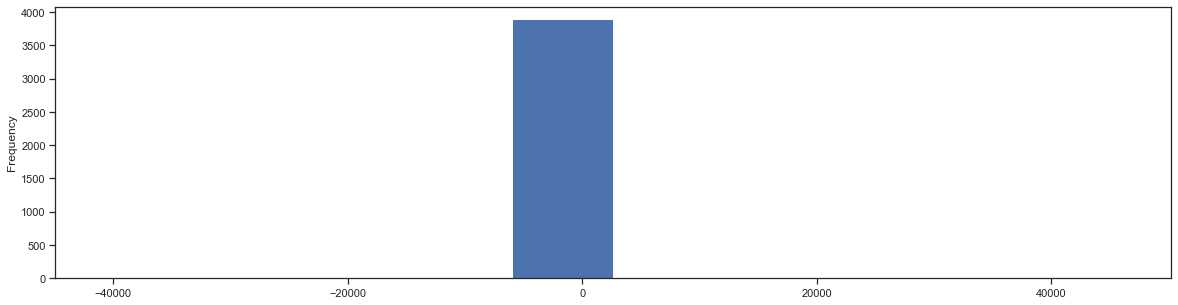

In [103]:
df_product_review_finall_all['number_of_reviews_avg_diff'].plot(kind = "hist")

Seems most products have less reviews during pandamic.

<AxesSubplot:ylabel='Frequency'>

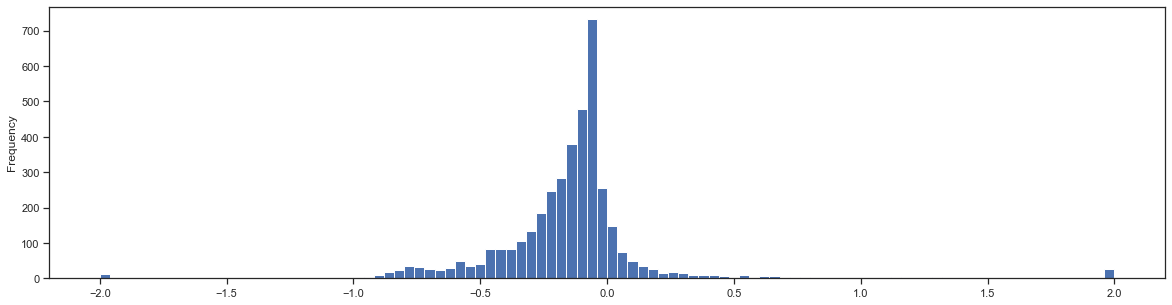

In [104]:
(df_product_review_finall_all['number_of_reviews_avg_diff'].div(df_product_review_finall_all['number_of_reviews_avg_2020'])).clip(-2,2).plot(kind = "hist", bins = 100)

In [105]:
df_category = (df_product_review_finall_all.set_index('category_level1')['number_of_reviews_avg_diff'].\
               div(df_product_review_finall_all.set_index('category_level1')['number_of_reviews_avg_2020'])).clip(-2,2)

In [106]:
#for i in df_category.index[:5]:
 #   plt.hist(df_category.loc[i], bins = 30, alpha = 0.2);
    

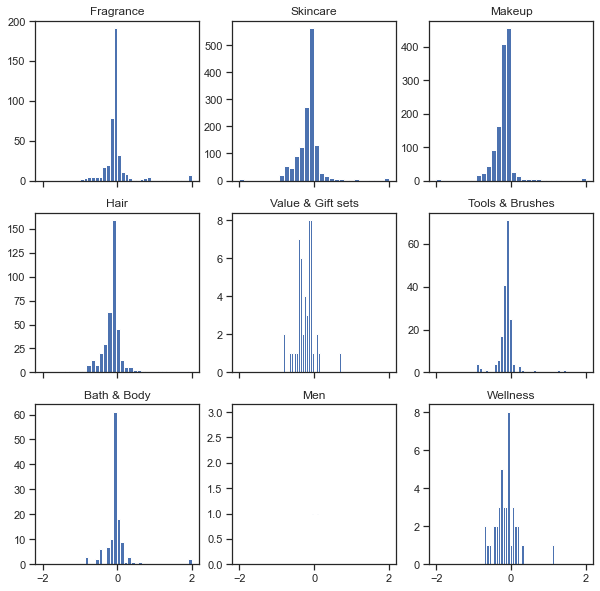

In [107]:
figure, axes = plt.subplots(3,3, figsize = (10,10), sharex = True)
for i,ax in zip(df_category.index.unique(),
            axes.reshape(-1)):
    ax.hist(df_category.loc[i], bins = 30);
    ax.set_title(i)

Seems all categories have less reviews during pandamic.

In [327]:
#df_product_2020_2021.sort_values(by ="number_of_reviews_2021_pandamic" , ascending=False)

In [109]:
#the data scrapped from Sephera is in SKU level (e.g. same product but different color). however, the kaggle data is in product family level. 
#the name is the product family name. Supernova Crushed Diamond Highlighter Pure(SKU id: 2325223) vs Supernova Crushed Diamond Highlighter
#The review is related to the product family. Therefore, we only care on product family level. 
#df_product_list.loc[df_product_list['Product_id']=="P454768",:]

In [111]:
#Analyze product life more than 2 years. we can compare the before pandamic vs pandamic 
df_product_review_finall_all['2_year_product_review_diff'] = df_product_review_finall_all['number_of_reviews_2021_pandamic_calculated']-\
                                                            df_product_review_finall_all['number_of_reviews_2020_b4pandamic']


In [112]:
df_product_review_finall_all['2_year_product_rating_diff'] = df_product_review_finall_all['Calculated_Rating_avg_2020-2021']-\
                                                            df_product_review_finall_all['Calculated_Rating_avg_2019-2020']


## Category level analysis 

In [114]:
df_product_review_finall_all['category_level1'].value_counts()

Skincare             1393
Makeup               1288
Fragrance             405
Hair                  386
Tools & Brushes       182
Bath & Body           124
Value & Gift sets      49
Wellness               40
Nail                   23
Men                    12
Name: category_level1, dtype: int64

In [323]:
#df_product_review_finall_all['category_level2'].value_counts()

In [110]:
df_product_review_finall_all['brand'].value_counts()

SEPHORA COLLECTION    202
CLINIQUE              125
Fresh                  78
tarte                  72
Lancôme                70
                     ... 
Black Up                1
Alpha-H                 1
8Greens                 1
Vital Proteins          1
Kenzo                   1
Name: brand, Length: 276, dtype: int64

In [111]:
#df_product_review_finall_all[df_product_review_finall_all['brand'] == "La Mer"]

In [112]:
#df_product_review_finall_all.groupby('brand').agg({"price":'median'}).sort_values(by = "price", ascending = False)

In [115]:
df_product_review_finall_all.groupby('category_level1').agg({"price":'median'}).sort_values(by = "price", ascending = False)

,price
category_level1,
Fragrance,92.0
Skincare,39.5
Value & Gift sets,39.0
Wellness,32.5
Bath & Body,32.0
Makeup,29.0
Tools & Brushes,29.0
Hair,28.0
Men,25.0


In [114]:
#df_product_review_finall_all.groupby('category_level2').agg({"price":'median'}).sort_values(by = "price", ascending = False)

## dataframe to analyze two year product life 

In [116]:
#dataframe to analyze two year product life 
df_product_review_2_year = df_product_review_finall_all.loc[df_product_review_finall_all["product_life_above_2"]=="True",:].copy()

In [117]:
#df_product_review_2_year.sort_values(by = 'number_of_reviews_2021_pandamic', ascending = False).head(30)

In [118]:
df_product_review_finall_all.sum()

Product_id                                    P163604P307801P388670P405269P388770P388766P398...
name                                          ColoniaFico di AmalfiRosa NobileMediterranean ...
size                                          0.7 oz/ 20 mL5 oz/ 148 mL3.4 oz/ 101 mL1.7 oz/...
brand                                         Acqua Di ParmaAcqua Di ParmaAcqua Di ParmaAERI...
category                                      ColognePerfumePerfumePerfumePerfumePerfumeLip ...
category_level1                               FragranceFragranceFragranceFragranceFragranceF...
category_level2                               FragranceFragranceFragranceFragranceFragranceF...
price                                                                                    176851
value_price                                                                              179161
URL                                           https://www.sephora.com/product/colonia-P16360...
love                                    

# Visualization - correlation price, like, number of review and rating 2020

In [120]:
df_splom = df_product_review_finall_all.loc[:,['product_life',"category_level1",'price','love','number_of_reviews_2021','rating_2021']]

In [121]:
df_heatmap = df_product_review_finall_all.loc[:,['product_life','price','love','number_of_reviews_2021','rating_2021']]

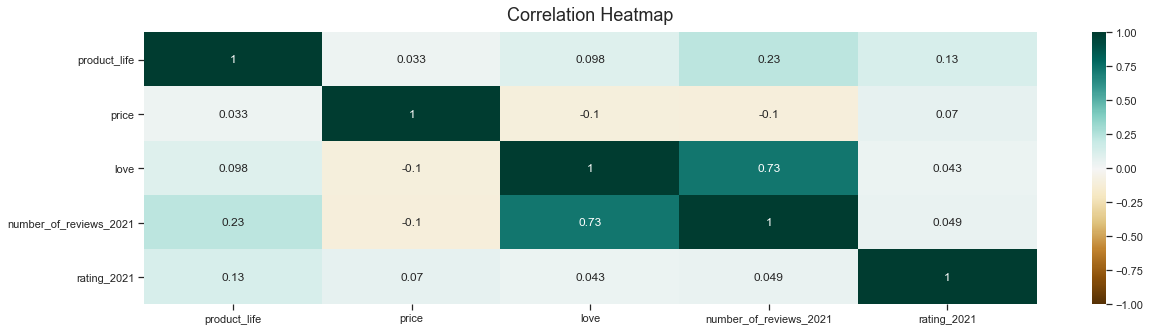

In [122]:
heatmap = sns.heatmap(df_heatmap.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [123]:
# df_splom['love']= np.log(df_splom['love'].clip(0.00000001, ))
# df_splom['number_of_reviews_2020'] = np.log(df_splom['number_of_reviews_2020'])
# df_splom['price'] = df_splom['price'].clip(0, 150)

In [124]:
df_splom.describe(percentiles = (0,0.98))

,product_life,price,love,number_of_reviews_2021,rating_2021
count,3902.000000,3902.000000,3.902000e+03,3902.000000,3902.000000
mean,5.353681,45.323232,3.150538e+04,743.055613,4.267932
std,3.542106,36.530425,5.977794e+04,1422.549170,0.255770
min,-0.001762,2.000000,0.000000e+00,4.000000,3.120300
0%,-0.001762,2.000000,0.000000e+00,4.000000,3.120300
50%,4.178689,34.000000,1.420000e+04,292.000000,4.280800
98%,12.595282,140.000000,1.934760e+05,4870.880000,4.739700
max,12.599399,549.000000,1.300000e+06,19576.000000,4.921900


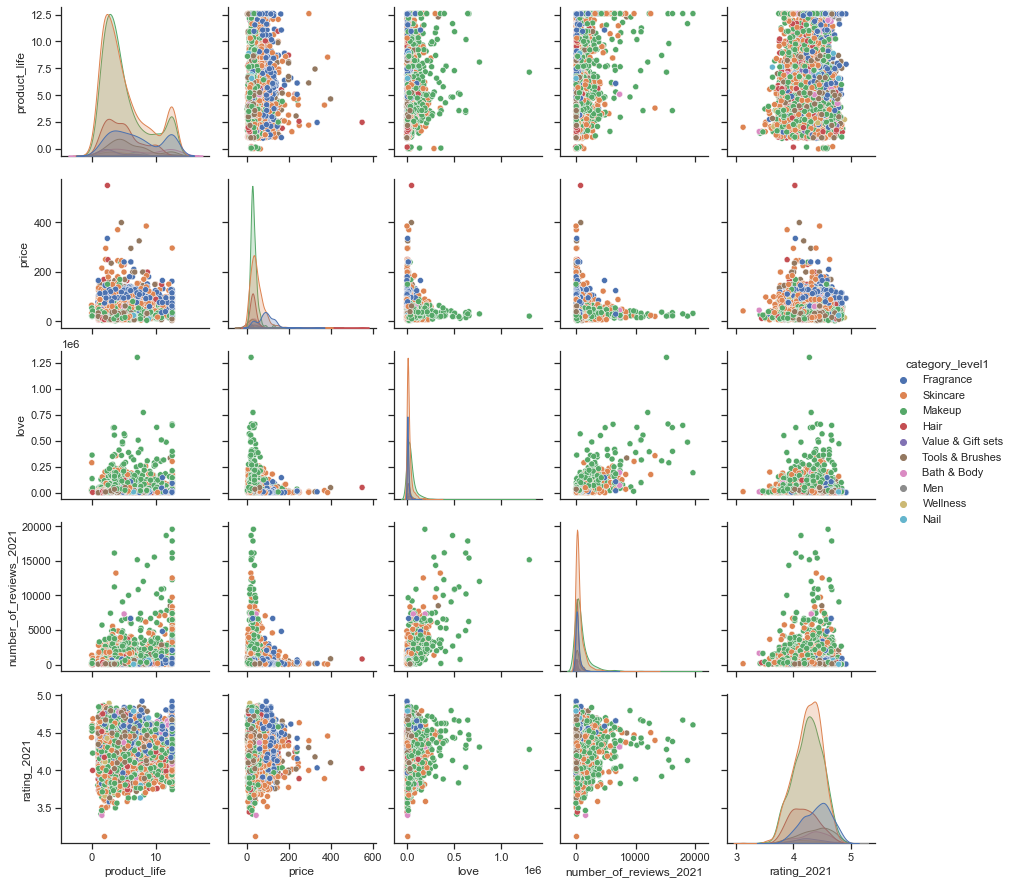

In [125]:
#df = sns.load_dataset("penguins")
sns.pairplot(df_splom, hue="category_level1")

## Analyzie in category level- product life above or equal to 2 years

In [126]:
df_product_review_2_year.groupby('category_level1')\
.agg({"price":'median', "Product_id":'count',"number_of_reviews_2021_pandamic_calculated":["median",'mean','max','min','sum'],"2_year_product_rating_diff":"mean" })\
.apply(lambda x: np.round(x, 2))\
.sort_values(by = ("price",'median'), ascending = False)\
.style.bar(color = 'lightblue')

In [127]:
df_product_review_2_year.groupby('category_level2')\
.agg({"price":'median', "number_of_reviews_2021_pandamic_calculated":["median",'mean','max','min','sum'],"2_year_product_rating_diff":"mean" })\
.apply(lambda x: np.round(x, 2))\
.sort_values(by = ("price",'median'), ascending = False)\
.style.bar(color = 'lightblue')

### Top 1 review product per category level 1

In [128]:
mapper3 = df_product_review_finall_all['name'].to_dict()

In [130]:
df_result = df_product_review_finall_all.groupby('category_level1')\
.agg({"Product_id":"count","price":'median', "2_year_product_review_diff":["mean",'max','min','sum', 'idxmax'],"2_year_product_rating_diff":"mean" })\
.apply(lambda x: np.round(x, 2))\
.sort_values(by = ("Product_id",'count'), ascending = False)

df_result[('2_year_product_review_diff', 'idxmax')] = df_result[('2_year_product_review_diff', 'idxmax')].map(mapper3)

df_result.style.bar(color = 'lightblue')

## visualize the matrix of reviews changed vs rating changed 

In [131]:
review_count = df_product_review_2_year['2_year_product_review_diff'].clip(-1000,1000)
rating = df_product_review_2_year['2_year_product_rating_diff']

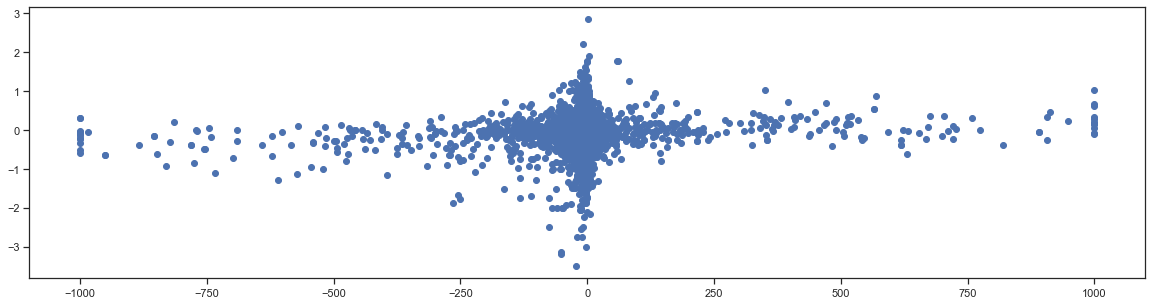

In [132]:
plt.scatter(review_count, rating)

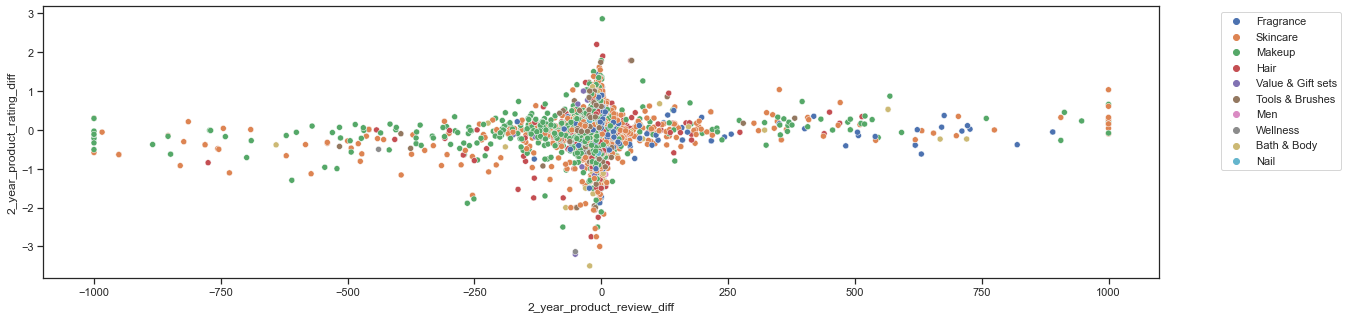

In [133]:
sns.scatterplot(data = df_product_review_2_year, x=review_count, y = rating, hue = 'category_level1');
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left');

In [136]:
df_product_review_2_year.shape

(3317, 30)

In [137]:
df_product_review_finall_all.head(3)

,Product_id,name,size,brand,category,category_level1,category_level2,price,value_price,URL,love,FirstSubmissionTime,product_life,product_life_above_1,product_life_above_2,number_of_reviews_2021,number_of_reviews_2020_calculated,number_of_reviews_2020,number_of_reviews_avg_2021,number_of_reviews_avg_2020,number_of_reviews_avg_diff,rating_2021,rating_2020,number_of_reviews_2021_pandamic_calculated,number_of_reviews_2020_b4pandamic,Calculated_Rating_avg_2020-2021,Calculated_Rating_avg_2019-2020,r_Submission_min_2021,2_year_product_review_diff,2_year_product_rating_diff
0,P163604,Colonia,0.7 oz/ 20 mL,Acqua Di Parma,Cologne,Fragrance,Fragrance,66.0,66.0,https://www.sephora.com/product/colonia-P16360...,2700,2008-09-11T23:37:06.000+00:00,12.558948,True,True,77,76.0,76,6.131087,6.574993,-0.443906,4.2987,4.5,1.0,6.574993,4.2987,4.500000,NaT,-5.574993,-0.201300
1,P307801,Fico di Amalfi,5 oz/ 148 mL,Acqua Di Parma,Perfume,Fragrance,Fragrance,180.0,180.0,https://www.sephora.com/product/blu-mediterran...,2600,2012-05-03T23:42:53.000+00:00,8.915101,True,True,85,79.0,79,9.534384,9.980921,-0.446537,4.5765,4.5,6.0,51.000000,4.5000,4.705882,2020-04-15 20:22:49,-45.000000,-0.205882
2,P388670,Rosa Nobile,3.4 oz/ 101 mL,Acqua Di Parma,Perfume,Fragrance,Fragrance,210.0,210.0,https://www.sephora.com/product/rosa-nobile-P3...,5000,2014-08-24T07:11:04.000+00:00,6.607399,True,True,86,79.0,79,13.015712,14.088528,-1.072817,4.6163,4.5,7.0,14.088528,4.6163,4.500000,NaT,-7.088528,0.116300


In [87]:
df_product_review_finall_all.describe()

,price,value_price,love,product_life,number_of_reviews_2021,number_of_reviews_2020_calculated,number_of_reviews_2020,number_of_reviews_avg_2021,number_of_reviews_avg_2020,number_of_reviews_avg_diff,rating_2021,rating_2020,number_of_reviews_2021_pandamic_calculated,number_of_reviews_2020_b4pandamic,Calculated_Rating_avg_2020-2021,Calculated_Rating_avg_2019-2020
count,3902.000000,3902.000000,3.902000e+03,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000
mean,45.323232,45.915210,3.150538e+04,5.356421,743.055613,646.854434,585.184777,198.515287,281.325073,-82.809786,4.267932,4.307022,96.201179,226.585717,4.073619,4.198253
std,36.530425,37.312424,5.977794e+04,3.542106,1422.549170,1332.090064,1234.555546,970.336816,729.727729,1097.961420,0.255770,0.271800,214.559076,712.009990,0.500256,0.401809
min,2.000000,2.000000,0.000000e+00,0.000977,4.000000,0.000000,50.000000,4.298609,0.000000,-17779.659374,3.120300,4.000000,0.000000,0.000000,1.000000,1.000000
25%,25.000000,25.000000,6.825000e+03,2.614936,135.250000,106.000000,108.000000,32.242245,35.177207,-39.281751,4.087575,4.000000,10.000000,21.000000,3.839771,4.000000
50%,34.000000,34.000000,1.420000e+04,4.181428,292.000000,230.000000,231.000000,72.937883,84.440361,-7.950600,4.280800,4.500000,29.000000,51.000000,4.153846,4.241379
75%,54.000000,54.000000,3.250000e+04,7.442771,747.000000,612.000000,613.000000,192.491798,249.628152,-1.551537,4.455050,4.500000,84.000000,151.464231,4.400000,4.500000
max,549.000000,549.000000,1.300000e+06,12.602139,19576.000000,19473.000000,19000.000000,41945.693431,20492.293107,41945.693431,4.921900,5.000000,4236.000000,20492.293107,5.000000,5.000000


- product_life is negative
- number_of_reviews_avg_2021 is negative 

# Select the products that can bring happiness to people during the covid-19. 

we build up a model to calcalate happiness score: we have five indicators, each indicator is normalized to [0,1], the happiness score is the sum of the five indicators. 

the five indicators are:
- number of reviews 2021
- number of rating 2021
- 

# Review time series analysis 

In [190]:
df_example = df_reviews[(df_reviews["Product_id_original"]=="P378716")]

In [191]:
df_example.iloc[1000,:]

Id                                                                                          51729742
ProductId                                                                                    P378716
Rating                                                                                             5
Title                                                                                        amazing
ReviewText                                         I have continuously purchased this because it'...
IsRecommended                                                                                   None
SubmissionTime                                                         2015-10-25T16:29:47.000+00:00
ContextDataValues.skinType.ValueLabel                                                            NaN
ContextDataValues.eyeColor.ValueLabel                                                            NaN
ContextDataValues.hairColor.ValueLabel                                                     

In [192]:
df_reviews.head(2)

,Id,ProductId,Rating,Title,ReviewText,IsRecommended,SubmissionTime,ContextDataValues.skinType.ValueLabel,ContextDataValues.eyeColor.ValueLabel,ContextDataValues.hairColor.ValueLabel,ContextDataValues.skinTone.ValueLabel,ContextDataValues.age.ValueLabel,ContextDataDistribution.skinConcerns.ValueLabel,Product_id_original,review_submission_time
0,173658866,P443401,2,Too similar and no lasting power,I bought this because I already love Arancia d...,False,2021-02-15T18:09:41.000+00:00,Combination,Blue,Blonde,Fair,NaN,NaN,P443401,2021-02-15 18:09:41
1,173618877,P443401,1,None,Why is this 82$ when the value is lower? That ...,False,2021-02-14T17:22:53.000+00:00,Combination,Green,Blonde,Fair,NaN,NaN,P443401,2021-02-14 17:22:53


In [193]:
#group by category, see the review changes per category

In [194]:
df_reviews_2021.head(2)

,Id,ProductId,Rating,Title,ReviewText,IsRecommended,SubmissionTime,ContextDataValues.skinType.ValueLabel,ContextDataValues.eyeColor.ValueLabel,ContextDataValues.hairColor.ValueLabel,ContextDataValues.skinTone.ValueLabel,ContextDataValues.age.ValueLabel,ContextDataDistribution.skinConcerns.ValueLabel,Product_id_original,review_submission_time
0,173658866,P443401,2,Too similar and no lasting power,I bought this because I already love Arancia d...,False,2021-02-15T18:09:41.000+00:00,Combination,Blue,Blonde,Fair,NaN,NaN,P443401,2021-02-15 18:09:41
1,173618877,P443401,1,None,Why is this 82$ when the value is lower? That ...,False,2021-02-14T17:22:53.000+00:00,Combination,Green,Blonde,Fair,NaN,NaN,P443401,2021-02-14 17:22:53


In [195]:
df_reviews_2021['category_level1']=df_reviews_2021['ProductId'].map(mapper_product_category_1)
df_reviews_2021['category_level2']=df_reviews_2021['ProductId'].map(mapper_product_category_2)

In [94]:
df_reviews_2021["review_submission_time_d"] = pd.to_datetime(df_reviews_2021["review_submission_time"]).dt.floor('D')

In [197]:
df_reviews_2021_ts = df_reviews_2021.groupby(['review_submission_time_d',"category_level1"]).agg({"Id": 'count'}).reset_index()

In [198]:
df_reviews_2021_ts= df_reviews_2021_ts.set_index(["review_submission_time_d", 'category_level1']).unstack()

In [199]:
df_reviews_2021_ts.columns = [i[1] for i in df_reviews_2021_ts.columns]

In [200]:
#note that the two years data might not be comparable as the people might move from offline to online 

In [ ]:
d_reviews[]

In [201]:
df_reviews_2021_ts.sum()

Bath & Body           10820.0
Fragrance             28982.0
Hair                  26535.0
Makeup                40058.0
Men                      56.0
Nail                    165.0
Skincare             158357.0
Tools & Brushes        4877.0
Value & Gift sets      2198.0
Wellness               2250.0
dtype: float64

In [202]:
df_reviews_2021_ts = df_reviews_2021_ts.resample('W').sum()

In [203]:
# df_reviews_2021_ts = df_reviews_2021_ts.rolling('7D').mean()

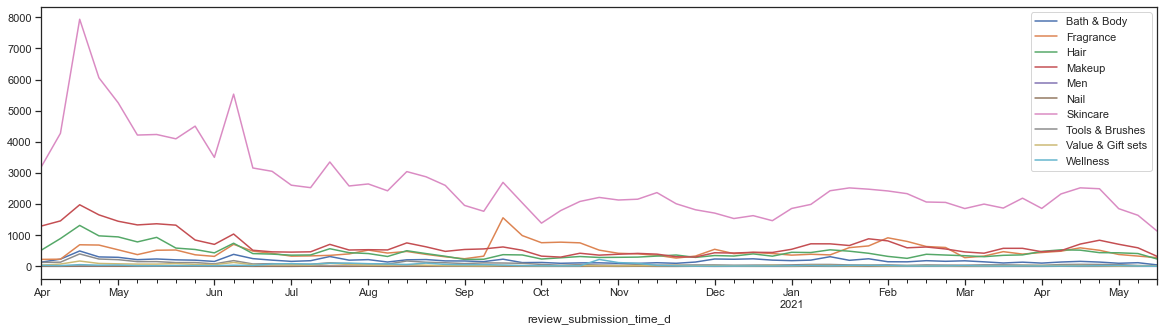

In [204]:
# plt.plot( df_reviews_2021_ts, );
df_reviews_2021_ts.fillna(0).plot()
plt.legend()

In [229]:
df_reviews_2021_ts = df_reviews_2021.groupby(['review_submission_time_d',"category_level1"]).agg({"Rating": 'mean'}).reset_index()

In [234]:
df_reviews_2021_ts

,Bath & Body,Fragrance,Hair,Makeup,Men,Nail,Skincare,Tools & Brushes,Value & Gift sets,Wellness
review_submission_time_d,,,,,,,,,,
2020-04-30,4.159558,4.468851,4.083708,4.227438,3.333333,3.511111,4.094536,4.310526,4.090656,4.084783
2020-05-31,4.080371,4.351496,3.974742,4.172324,4.400000,4.495370,4.044312,4.275420,3.927988,3.495476
2020-06-30,4.012928,4.183695,3.969837,4.094330,4.000000,4.533333,4.104236,4.193013,4.047297,3.910454
2020-07-31,3.964612,4.246381,3.931812,4.006365,3.900000,4.166667,4.063278,4.298492,4.034181,3.805428
2020-08-31,4.054019,4.123182,3.921924,4.135726,4.428571,4.307692,4.123173,4.196215,3.923692,3.625098
2020-09-30,3.984510,4.227604,3.928989,4.147809,5.000000,4.666667,4.159095,4.260721,4.010417,4.078955
2020-10-31,3.793495,4.323139,3.899657,3.997367,5.000000,4.562500,4.201725,4.114910,4.112778,4.579819
2020-11-30,4.007848,4.210337,3.979838,3.972425,3.400000,4.142857,4.227073,4.201865,3.905102,4.387694
2020-12-31,4.228383,4.320427,4.113024,4.021022,5.000000,3.666667,4.119824,3.762762,4.167931,4.052500


In [230]:
df_reviews_2021_ts= df_reviews_2021_ts.set_index(["review_submission_time_d", 'category_level1']).unstack()

In [231]:
df_reviews_2021_ts.columns = [i[1] for i in df_reviews_2021_ts.columns]

In [232]:
df_reviews_2021_ts = df_reviews_2021_ts.resample('M').mean()

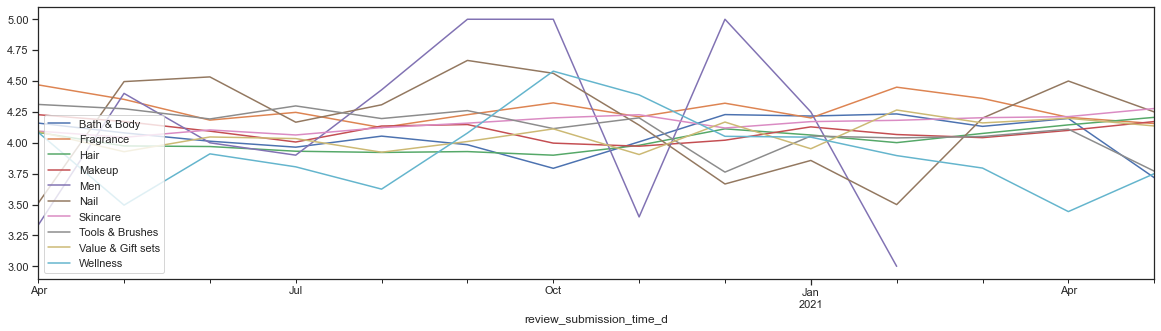

In [233]:
# plt.plot( df_reviews_2021_ts, );
df_reviews_2021_ts.plot()
plt.legend()

<AxesSubplot:xlabel='review_submission_time_d'>

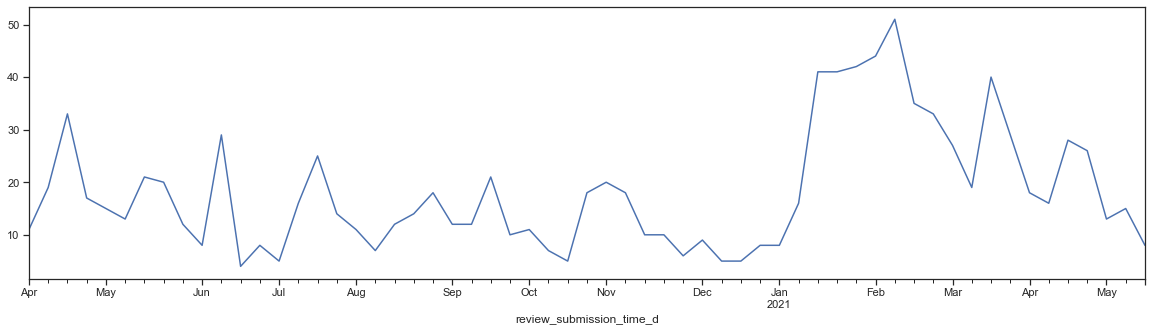

In [303]:
df_reviews_2021.set_index('review_submission_time_d')['ReviewText'].str.lower().str.contains('covid|pandemic|virus').resample('W').sum().plot()

In [304]:
df_covid = df_reviews_2021.set_index(['review_submission_time_d', 'category_level1'])['ReviewText'].str.lower().str.contains('covid|pandemic|virus')

In [305]:
df_covid = pd.DataFrame(df_covid)

In [306]:
df_covid = df_covid.reset_index()

In [307]:
df_covid = df_covid.groupby(['review_submission_time_d', 'category_level1'])['ReviewText'].sum().unstack()

<AxesSubplot:xlabel='review_submission_time_d'>

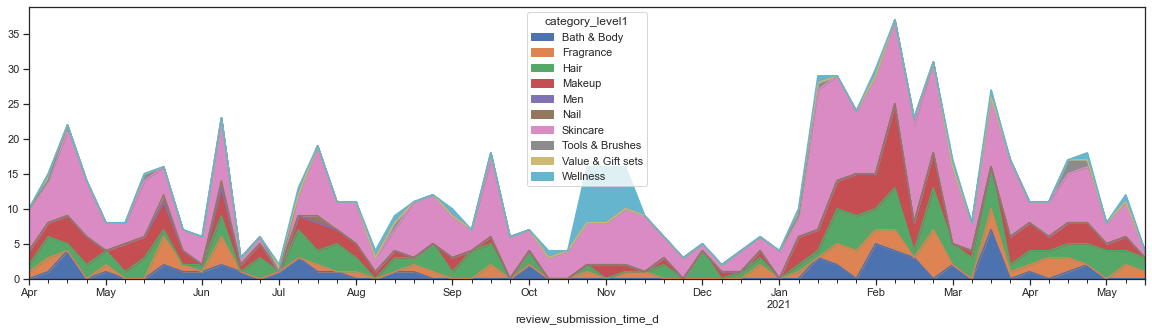

In [308]:
df_covid.resample('W').sum().plot(kind = 'area')

In [309]:
df_covid = df_covid.resample('W').sum()

In [310]:
df_covid['sum'] = df_covid.sum(axis = 1)

In [311]:
df_covid.columns

Index(['Bath & Body', 'Fragrance', 'Hair', 'Makeup', 'Men', 'Nail', 'Skincare',
       'Tools & Brushes', 'Value & Gift sets', 'Wellness', 'sum'],
      dtype='object', name='category_level1')

In [312]:
for i in ['Bath & Body', 'Fragrance', 'Hair', 'Makeup', 'Men', 'Nail', 'Skincare',
       'Tools & Brushes', 'Value & Gift sets', 'Wellness', 'sum']:
    df_covid[i] = df_covid[i]/df_covid['sum']

<AxesSubplot:xlabel='review_submission_time_d'>

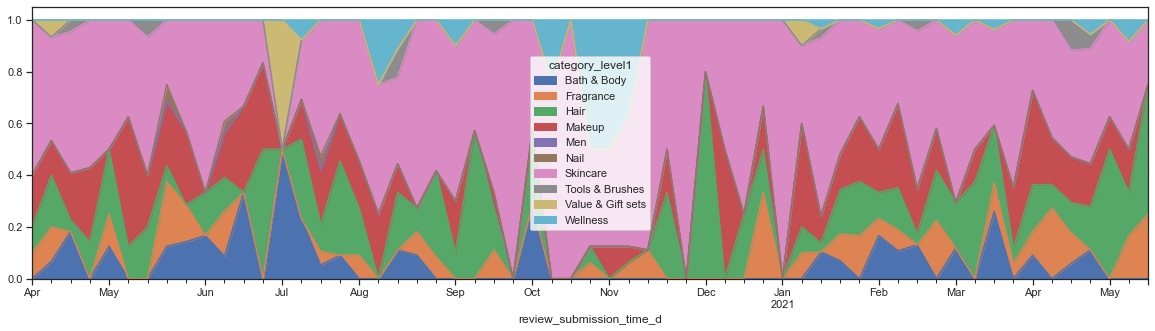

In [313]:
df_covid.iloc[:, :-1].plot(kind = 'area')

# Joy

<AxesSubplot:xlabel='review_submission_time_d'>

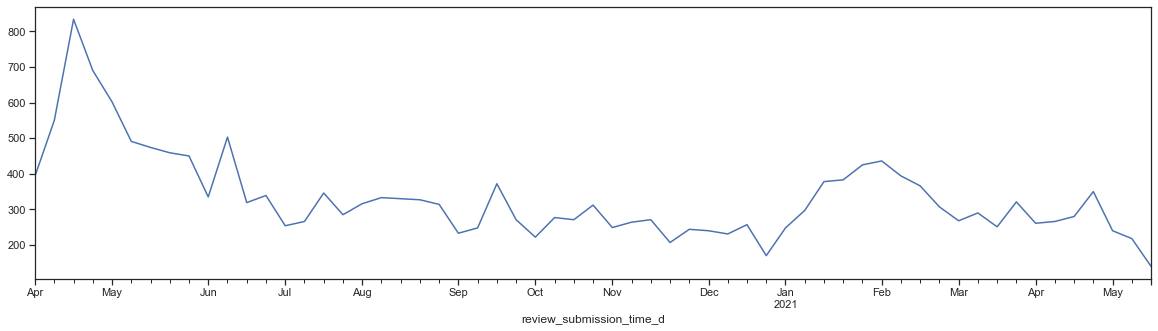

In [261]:
df_reviews_2021.set_index('review_submission_time_d')['ReviewText'].str.lower().str.contains('happy|joy|happiness|relax').resample('W').sum().plot()

In [289]:
df_covid = df_reviews_2021.set_index(['review_submission_time_d', 'category_level1'])['ReviewText'].str.lower().str.contains('happy|joy|happiness|relax')

In [290]:
df_covid = pd.DataFrame(df_covid)

In [291]:
df_covid = df_covid.reset_index()

In [292]:
df_covid = df_covid.groupby(['review_submission_time_d', 'category_level1'])['ReviewText'].sum().unstack()

<AxesSubplot:xlabel='review_submission_time_d'>

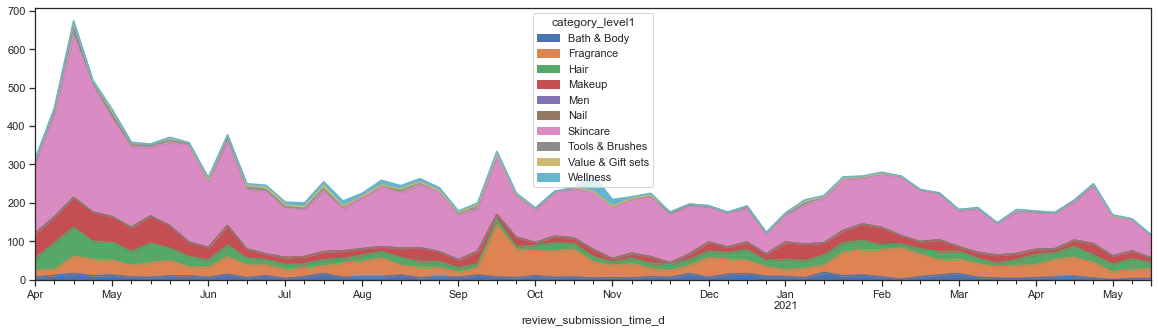

In [293]:
df_covid.resample('W').sum().plot(kind = 'area')

In [294]:
df_covid = df_covid.resample('W').sum()

In [295]:
df_covid['sum'] = df_covid.sum(axis = 1)

In [297]:
df_covid.columns

Index(['Bath & Body', 'Fragrance', 'Hair', 'Makeup', 'Men', 'Nail', 'Skincare',
       'Tools & Brushes', 'Value & Gift sets', 'Wellness', 'sum'],
      dtype='object', name='category_level1')

In [300]:
for i in ['Bath & Body', 'Fragrance', 'Hair', 'Makeup', 'Men', 'Nail', 'Skincare',
       'Tools & Brushes', 'Value & Gift sets', 'Wellness', 'sum']:
    df_covid[i] = df_covid[i]/df_covid['sum']

<AxesSubplot:xlabel='review_submission_time_d'>

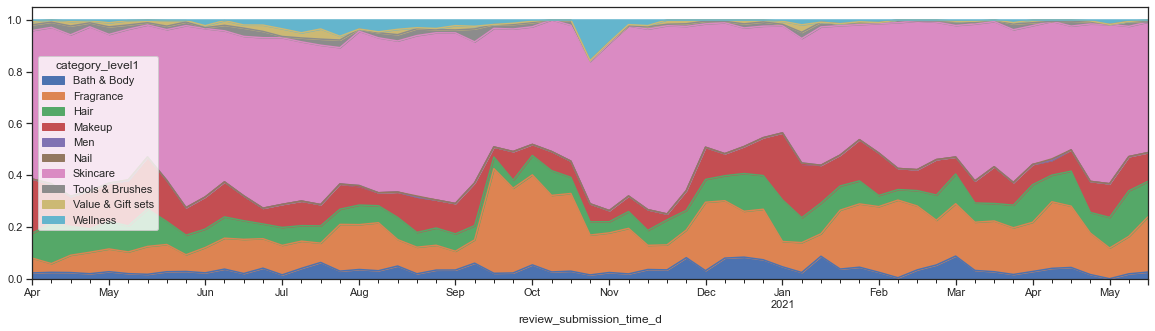

In [302]:
df_covid.iloc[:, :-1].plot(kind = 'area')

In [236]:
df_reviews_2021

,Id,ProductId,Rating,Title,ReviewText,IsRecommended,SubmissionTime,ContextDataValues.skinType.ValueLabel,ContextDataValues.eyeColor.ValueLabel,ContextDataValues.hairColor.ValueLabel,ContextDataValues.skinTone.ValueLabel,ContextDataValues.age.ValueLabel,ContextDataDistribution.skinConcerns.ValueLabel,Product_id_original,review_submission_time,category_level1,category_level2,review_submission_time_d
0,173658866,P443401,2,Too similar and no lasting power,I bought this because I already love Arancia d...,False,2021-02-15T18:09:41.000+00:00,Combination,Blue,Blonde,Fair,NaN,NaN,P443401,2021-02-15 18:09:41,Fragrance,Fragrance,2021-02-15
1,173618877,P443401,1,None,Why is this 82$ when the value is lower? That ...,False,2021-02-14T17:22:53.000+00:00,Combination,Green,Blonde,Fair,NaN,NaN,P443401,2021-02-14 17:22:53,Fragrance,Fragrance,2021-02-14
2,167552732,P443401,4,"Not long lasting enough, a bit too feminine",I had a few of these as samples and really lik...,True,2020-12-10T05:36:56.000+00:00,Combination,Brown,Brunette,Light,NaN,NaN,P443401,2020-12-10 05:36:56,Fragrance,Fragrance,2020-12-10
3,165457313,P443401,3,"Great scents, no lasting power",Fell in love with Acqua Di Parma during a stay...,True,2020-11-10T21:32:24.000+00:00,Combination,Brown,Brunette,Light,NaN,NaN,P443401,2020-11-10 21:32:24,Fragrance,Fragrance,2020-11-10
4,158567125,P443401,5,None,I've had this set for a year now and I constan...,True,2020-06-23T02:52:58.000+00:00,Normal,Brown,Brunette,Porcelain,NaN,NaN,P443401,2020-06-23 02:52:58,Fragrance,Fragrance,2020-06-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,155116225,P420024,5,None,I love this set of eye brushes! It is perfect!...,True,2020-04-19T21:38:26.000+00:00,Combination,Brown,Brunette,Medium,NaN,NaN,P420024,2020-04-19 21:38:26,Tools & Brushes,Eye Brushes,2020-04-19
2,155003891,P420024,5,None,Great brushes! The hold eyeshadow well and bl...,True,2020-04-16T20:09:40.000+00:00,Normal,Brown,Auburn,Medium,NaN,NaN,P420024,2020-04-16 20:09:40,Tools & Brushes,Eye Brushes,2020-04-16
3,154977781,P420024,4,None,Brushes are great for the price! Minus one sta...,True,2020-04-16T04:23:00.000+00:00,Normal,Brown,Brunette,Light,NaN,NaN,P420024,2020-04-16 04:23:00,Tools & Brushes,Eye Brushes,2020-04-16
4,154910549,P420024,5,Great deal for the money,Brushes are great. Nice for travel. Excellent ...,True,2020-04-15T19:38:12.000+00:00,Normal,Brown,Brunette,Olive,NaN,NaN,P420024,2020-04-15 19:38:12,Tools & Brushes,Eye Brushes,2020-04-15


In [205]:
df_reviews_2020.head(2)

,Id,ProductId,Rating,Title,ReviewText,IsRecommended,SubmissionTime,ContextDataValues.skinType.ValueLabel,ContextDataValues.eyeColor.ValueLabel,ContextDataValues.hairColor.ValueLabel,ContextDataValues.skinTone.ValueLabel,ContextDataValues.age.ValueLabel,ContextDataDistribution.skinConcerns.ValueLabel,Product_id_original,review_submission_time
5,132084231,P443401,5,None,"I really love this set, I can have 5 different...",True,2019-09-04T21:00:50.000+00:00,Combination,Brown,Black,Light,NaN,NaN,P443401,2019-09-04 21:00:50
6,131354293,P443401,1,None,Love every scent in this set. My old time favo...,False,2019-08-11T19:49:39.000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,P443401,2019-08-11 19:49:39


In [206]:
df_reviews_2021_temp = df_reviews_2021.groupby('Product_id_original').agg({"Rating": "mean", "Id": "count",'review_submission_time':'min'})\
.reset_index().rename(columns = {"Product_id_original":'Product_id', 'Rating':'r_Rating_avg_2021',\
                                 'Id':'r_Review_count_2021','review_submission_time':'r_Submission_min_2021'})

### Data manipulation

In [ ]:
df_product_list.head(1)

In [ ]:
product_info_list =['Product_id', 'name','category','brand', 'rating', 'number_of_reviews','love','price','URL']

In [ ]:
df_product_mapper = df_product_list.loc[:,product_info_list]

df_reviews.head(2)

In [ ]:
df_product.shape

In [ ]:
pandemic = df_reviews.groupby('Product_id_original')['SubmissionTime'].min()<='2020-04-01T00:00:00.00+00:00'

In [ ]:
pandemic

# Appendix

In [ ]:
df_product.head(5)

In [ ]:
df_reviews['ContextDataValues.age.ValueLabel'].fillna('Null').value_counts()

In [ ]:
# def translator_pid_id(df, traslate_df):
#     df['id'] = df['id'].astype(str)
#     mapper = df[['id', 'Product_id']].set_index('id').to_dict()['Product_id']
#     target_df = traslate_df.copy()
#     target_df['Product_id'] = target_df['Product_id'].map(mapper).fillna(target_df['Product_id'])
#     return target_df

In [ ]:
# df_product = translator_pid_id(df_product_list, df_product)

## Missing due to no reviews total 27

In [ ]:
df_filtered = pd.read_csv('./data/filtered sephora reviews.csv')

In [ ]:
len(df_filtered)

In [ ]:
df_filtered['Product_id'] = df_filtered['URL'].str.findall('P[0-9]{4,15}').apply(lambda x: x[0] if x!=[] else None)

In [ ]:
len(set(df_product.Product_id) & set(df_product_list.Product_id))

In [ ]:
# set(df_product.Product_id) - set(df_product_list.Product_id)

In [ ]:
len(set(df_filtered.Product_id) - set(df_product.Product_id_original))

In [ ]:
df_missing = df_filtered.loc[df_filtered.Product_id.isin((set(df_filtered.Product_id) - set(df_product.Product_id_original))),:]

In [ ]:
len(df_product)

In [ ]:
df_original = df_product_list.loc[df_product_list.id.isin(df_filtered['id'].astype(str)),:]

In [ ]:
df_original.loc[df_original.id.isin(df_missing.id.astype(str)), :].to_csv('data/27_missing.csv')

### Remove duplicated lines

In [ ]:
df_product = pd.read_pickle('data/all_products.pkl')

In [ ]:
df_reviews = pd.read_pickle('data/all_reviews.pkl')

In [ ]:
df_product = df_product[~df_product.duplicated(subset = ['Product_id_original'])]

In [ ]:
df_reviews = df_reviews[~df_reviews.duplicated()]

##### Test The % of time during pandemic covered by the selected 3000 reviews

In [ ]:
df_reviews

In [ ]:
df_product['RatingDistribution'].values[0]

In [ ]:
pandemic = (df_reviews.groupby('Product_id_original')['SubmissionTime'].min()<='2020-04-01T00:00:00.00+00:00').sum()

In [ ]:
pre_pandemic = (df_reviews.groupby('Product_id_original')['SubmissionTime'].min()<='2019-04-01T00:00:00.00+00:00').sum()

In [ ]:
pandemic / df_product.Product_id_original.nunique()

In [ ]:
pre_pandemic / df_product.Product_id_original.nunique()

In [ ]:
df_reviews.Product_id_original.nunique()

In [ ]:
df_product.to_pickle('data/all_products_no_dup.pkl')

In [ ]:
df_reviews.to_pickle('data/all_reviews_no_dup.pkl')

In [ ]:
df_product[df_product.duplicated('Product_id_original', keep = False)]

In [ ]:
with open('data/scope_list.pkl', 'rb') as file:
    scope_lst = pickle.load(file)

In [ ]:
len(scope_lst)

In [ ]:
df_all = pd.read_pickle('data/all_products.pkl')

In [ ]:
df_all[df_all['Product_id_original'] == 'P236816'] 2324705

## there are 99% products that have product life more than 1 year

In [ ]:
df_product_2020_2021[df_product_2020_2021['product_life']>=2].shape

In [ ]:
df_product_2020_2021

In [ ]:
3317/3902

## there are 85% products that have product life more than 2 years

In [ ]:
df_product_2020_2021[df_product_2020_2021['product_life']<1].shape

### there are 14 products that have product life less than 1 year. 

In [ ]:
df_product_2020_2021[df_product_2020_2021['product_life']>=1].shape

In [ ]:
3888/3902

In [146]:
df_mc_list = ["price","category_level1",'number_of_reviews_2021',
                                'rating_2021', 
                                 'Calculated_Rating_avg_2020-2021',
                                '2_year_product_review_diff',
                                '2_year_product_rating_diff',
                                 ]

In [147]:
df_mc=df_product_review_2_year.loc[:,df_mc_list].copy()

In [148]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [149]:
df_mc = pd.get_dummies(df_mc)

In [150]:
#df_mc

In [151]:
scaler = StandardScaler()

In [152]:
df_mc = scaler.fit_transform(df_mc)

In [153]:
model = KMeans(4)

In [154]:
model.fit(df_mc)

KMeans(n_clusters=4)

In [155]:
model.labels_

array([1, 1, 1, ..., 0, 0, 2], dtype=int32)

In [156]:
df_product_review_2_year['clusters'] = model.labels_

In [157]:
df_product_review_2_year.loc[:,['Product_id','name',"size","brand","category_level1","category_level2","price",'love', 'number_of_reviews_2021',
                                'rating_2021', 
                                 'Calculated_Rating_avg_2020-2021',
                                '2_year_product_review_diff',
                                '2_year_product_rating_diff','clusters']].to_csv('data/cluster_analysis_1.csv')

/Users/Destiny/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.


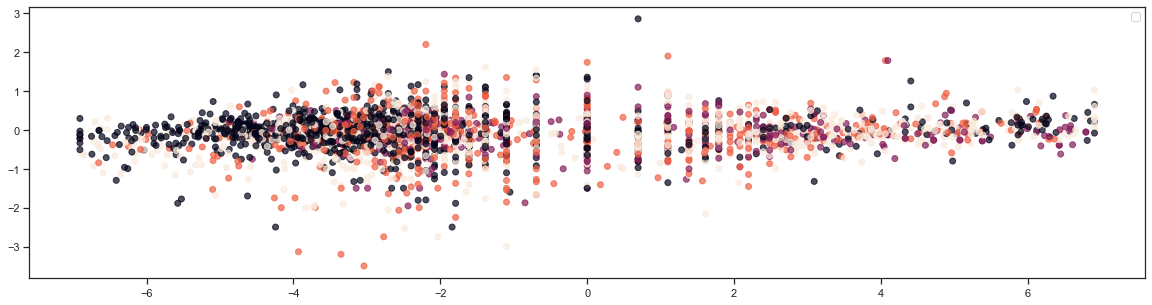

In [158]:
plt.scatter(np.sign(review_count)*np.log(np.abs(review_count)), rating, c = model.labels_, alpha = 0.7);
plt.legend()

In [159]:
df_mc_list = ["price",'love','category_level1', 'number_of_reviews_2021','2_year_product_rating_diff'
    
                                 ]

In [160]:
df_mc_selected_list = (df_product_review_2_year['2_year_product_review_diff']>=0) &\
                        (df_product_review_2_year['2_year_product_rating_diff']>=0)

In [161]:
df_selected=df_product_review_2_year.loc[df_mc_selected_list,:].copy()

In [162]:
df_mc_selected=df_product_review_2_year.loc[df_mc_selected_list,df_mc_list].copy()

In [163]:
df_mc_selected.head(2)

,price,love,category_level1,number_of_reviews_2021,2_year_product_rating_diff
4,130.0,5600,Fragrance,92,0.644444
33,38.0,14600,Hair,289,0.282738


In [164]:
df_mc_selected.shape

(404, 5)

In [165]:
df_mc_selected = pd.get_dummies(df_mc_selected)

In [166]:
#df_mc

In [167]:
scaler = StandardScaler()

In [168]:
df_mc_selected_new = scaler.fit_transform(df_mc_selected)

In [169]:
df_mc_selected[[i for i in df_mc_selected if 'category' in i]] = df_mc_selected[[i for i in df_mc_selected if 'category' in i]]/10

In [170]:
model2 = KMeans(4)

In [171]:
model2.fit(df_mc_selected_new)

KMeans(n_clusters=4)

In [172]:
model2.labels_

array([1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 2, 2, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 3, 3, 3, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2, 2, 0, 1, 2, 0,
       1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 1, 0, 0, 0,
       0, 0, 0, 2, 1, 1, 2, 2, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 3, 2, 2,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 3, 3, 3, 3,
       2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 3, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 1, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0,

In [173]:
df_selected['clusters'] = model2.labels_

In [174]:
df_selected.head(2)

,Product_id,name,size,brand,category,category_level1,category_level2,price,value_price,URL,love,FirstSubmissionTime,product_life,product_life_above_1,product_life_above_2,number_of_reviews_2021,number_of_reviews_2020,number_of_reviews_avg_2021,number_of_reviews_avg_2020,number_of_reviews_avg_diff,rating_2021,rating_2020,number_of_reviews_2021_pandamic_calculated,number_of_reviews_2020_b4pandamic,Calculated_Rating_avg_2020-2021,Calculated_Rating_avg_2019-2020,r_Submission_min_2021,2_year_product_review_diff,2_year_product_rating_diff,clusters
4,P388770,Amber Musk,1.7 oz/ 50 mL,AERIN,Perfume,Fragrance,Fragrance,130.0,130.0,https://www.sephora.com/product/amber-musk-P38...,5600,2014-09-30T02:42:38.000+00:00,6.506540,True,True,92,77,14.139620,13.983373,0.156247,4.3261,4.5,15.0,9.0,4.533333,3.888889,2020-04-26 00:44:19,6.0,0.644444,1
33,P406531,REVEAL Concentrated Color Correcting Drops,0.5 oz/ 15 mL,Algenist,Color Correct,Hair,Hair care,38.0,38.0,https://www.sephora.com/product/reveal-concent...,14600,2016-02-19T22:56:27.000+00:00,5.115189,True,True,289,269,56.498397,65.367587,-8.869190,3.7855,4.0,21.0,16.0,4.095238,3.812500,2020-04-01 19:31:55,5.0,0.282738,3


In [175]:
df_selected.loc[:,['Product_id','name',"size","brand","category_level1","category_level2","price",'love', 'number_of_reviews_2021',
                                'rating_2021', 
                                 'Calculated_Rating_avg_2020-2021',
                                '2_year_product_review_diff',
                                '2_year_product_rating_diff','clusters']].to_csv('data/cluster_analysis_selected_2.csv')

In [176]:
review_count_2 = df_selected['2_year_product_review_diff'].clip(-1000,1000)
rating_2 = df_selected['2_year_product_rating_diff']

/Users/Destiny/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.


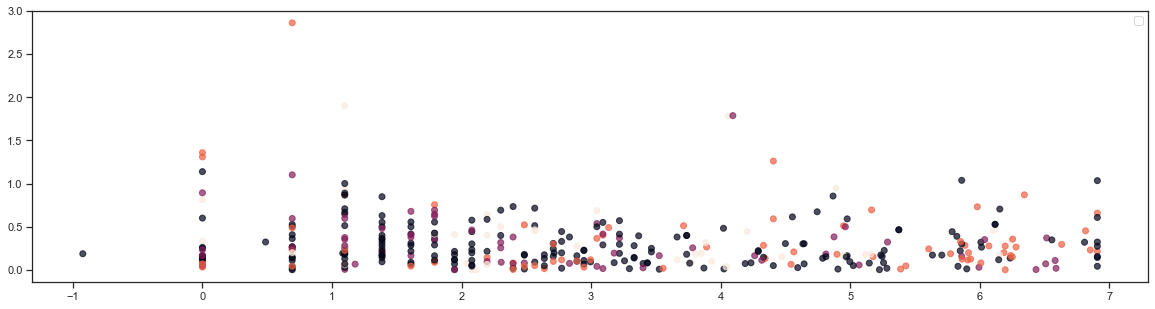

In [177]:
plt.scatter(np.sign(review_count_2)*np.log(np.abs(review_count_2)), rating_2, c = model2.labels_, alpha = 0.7);
plt.legend()

In [178]:
df_product_review_2_year.shape

(3317, 30)

In [135]:
#plt.hexbin(np.sign(review_count)*np.log(np.abs(review_count)), rating)#

In [145]:
## use machine learning to categorize

In [179]:
#dataframe to analyze one year product life 
df_product_review_1_year = df_product_review_finall_all.loc[df_product_review_finall_all["product_life_above_1"]=="True",:].copy()

In [184]:
review_count_2021 = df_product_review_1_year['number_of_reviews_2021_pandamic_calculated'].clip(0,6000)
rating_2021 = df_product_review_1_year['Calculated_Rating_avg_2020-2021']

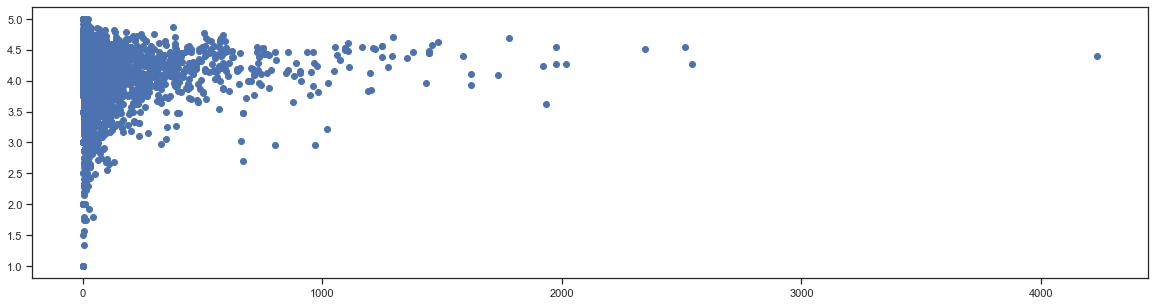

In [185]:
plt.scatter(review_count_2021, rating_2021)